# Irrigation Optimization Model Training & Analysis

This notebook walks through the process of loading data, training the irrigation optimization model, evaluating its performance, and visualizing results.

## 1. Import Required Libraries

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from catboost import CatBoostRegressor
import joblib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os

## 2. Load Data

In [ ]:
project_root = os.path.dirname(os.path.dirname(os.path.dirname(os.path.abspath("train_notebook.ipynb"))))
data_path = os.path.join(project_root, 'data', 'Final_irregation_optimization_data_m2.csv')
print(f"Loading data from: {data_path}")
merged_df = pd.read_csv(data_path)
merged_df.head()

Loading data from: c:\Abdallah\Intelligent-Crop-Irrigation-Advisor\data\Final_irregation_optimization_data_m2.csv


,soil_moisture,temperature,soil_humidity,time,air_temperature_(c),wind_speed_(km/h),humidity,wind_gust_(km/h),pressure_(kpa),ph,...,rain_effect,moisture_change_rate,temp_scaled,npk_balance,wind_ratio,recommended_water_mm,soil_moisture_updated,recommended_N,recommended_P,recommended_K
0,54.0,22.0,70.0,21.0,19.52,2.13,55.04,6.30,101.50,6.502985,...,30224.312898,0.000000,-0.107826,58.333333,0.291781,50.0,79.0,4.67,0.09,3.82
1,12.0,20.0,40.0,104.0,19.49,2.01,55.17,10.46,101.50,7.038096,...,48652.866185,0.000000,-0.024286,61.333333,0.175393,0.0,12.0,0.00,0.00,0.00
2,34.0,26.0,35.0,62.0,19.47,1.90,55.30,14.63,101.51,7.840207,...,60702.339593,0.628571,-0.241852,53.000000,0.121561,50.0,100.0,8.80,0.09,4.69
3,7.0,44.0,44.0,93.0,19.54,2.28,54.20,16.08,101.51,6.980401,...,57282.890868,-3.375000,-0.543556,49.666667,0.133489,0.0,100.0,0.00,0.00,0.00
4,50.0,38.0,23.0,92.0,19.61,2.66,53.09,17.52,101.51,7.628473,...,55884.533974,0.843137,-0.471538,54.000000,0.143629,0.0,100.0,0.00,0.00,0.00


## 3. Define Features and Target

In [ ]:
features = [
    'soil_moisture', 'temperature', 'soil_humidity', 'air_temperature_(c)',
    'wind_speed_(km/h)', 'humidity', 'wind_gust_(km/h)', 'pressure_(kpa)',
    'ph', 'rainfall', 'n', 'p', 'k', 'soil_moisture_diff',
    'Relative_Soil_Saturation', 'temp_diff', 'wind_effect',
    'Evapotranspiration', 'rain_3days', 'rain_vs_soil',
    'np_ratio', 'nk_ratio', 'ph_encoded', 'crop_encoded',
    'moisture_temp_ratio', 'evapo_ratio', 'rain_effect',
    'moisture_change_rate', 'temp_scaled', 'npk_balance', 'wind_ratio'
 ]
target = 'recommended_water_mm'
X = merged_df[merged_df['status'] == True][features]
y = merged_df[merged_df['status'] == True][target]

## 4. Visualize Training Data

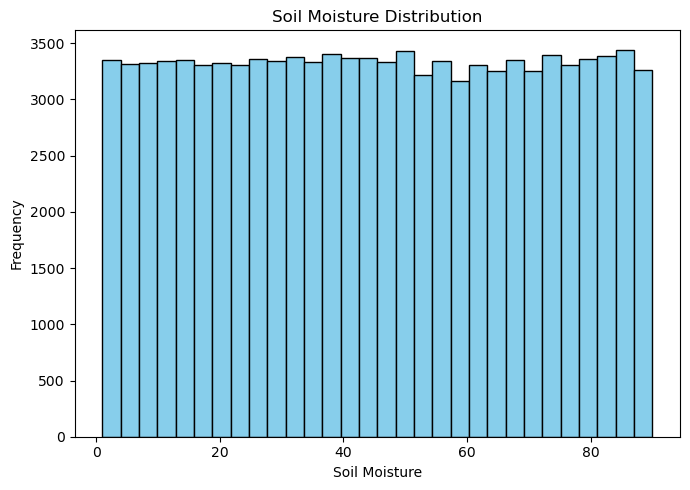

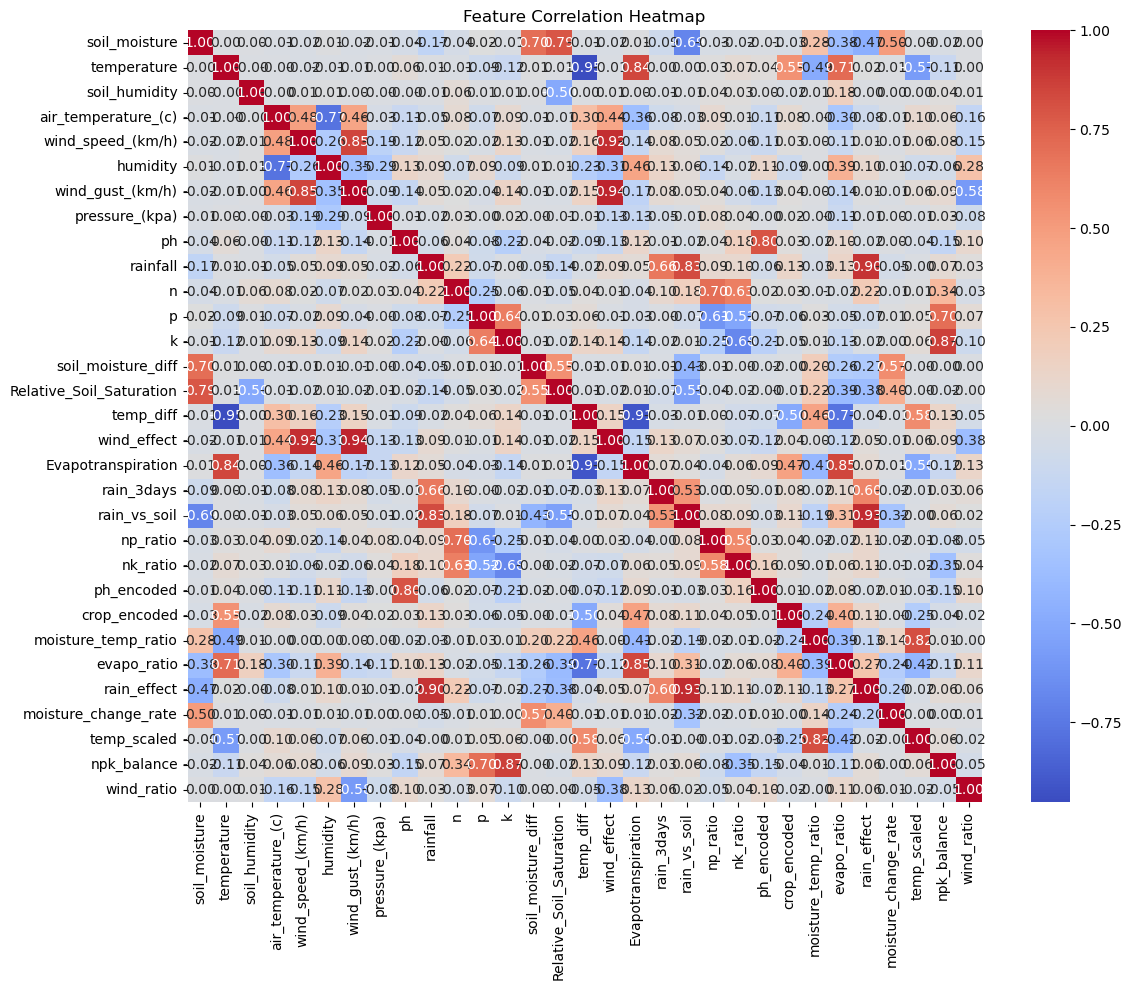

In [ ]:
# Feature distribution
plt.figure(figsize=(7,5))
plt.hist(merged_df['soil_moisture'], bins=30, color='skyblue', edgecolor='black')
plt.title('Soil Moisture Distribution')
plt.xlabel('Soil Moisture')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

## 5. Split Data

In [5]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## 6. Train Model

In [6]:
# Train CatBoost model
model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.05,
    depth=8,
    loss_function='RMSE',
    eval_metric='R2',
    random_seed=42,
    verbose=200
)
model.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True)

0:	learn: 0.0840764	test: 0.0844820	best: 0.0844820 (0)	total: 218ms	remaining: 3m 38s
200:	learn: 0.9781083	test: 0.9688939	best: 0.9688939 (200)	total: 5.19s	remaining: 20.6s
400:	learn: 0.9859901	test: 0.9725317	best: 0.9725317 (400)	total: 9.67s	remaining: 14.4s
600:	learn: 0.9900324	test: 0.9736148	best: 0.9736148 (600)	total: 14.1s	remaining: 9.37s
800:	learn: 0.9926996	test: 0.9741720	best: 0.9741720 (800)	total: 18.3s	remaining: 4.54s
999:	learn: 0.9945095	test: 0.9744071	best: 0.9744287 (952)	total: 22.9s	remaining: 0us

bestTest = 0.9744286917
bestIteration = 952

Shrink model to first 953 iterations.


## 7. Save Model

In [ ]:
joblib.dump(model, 'catboost_irrigation_model.pkl')
print("✅ Model saved successfully as 'catboost_irrigation_model.pkl'")

✅ Model saved successfully as 'catboost_irrigation_model.pkl'


## 8. Evaluate Model

In [ ]:
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
n = len(y_test)
p = len(features)
adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
print(f"\n📊 MAE: {mae:.3f}")
print(f"📉 RMSE: {rmse:.3f}")
print(f"🎯 R² Score: {r2:.3f}")
print(f"🔧 Adjusted R²: {adj_r2:.3f}")


📊 MAE: 0.683
📉 RMSE: 6.777
🎯 R² Score: 0.974
🔧 Adjusted R²: 0.974


## 9. Visualize Results

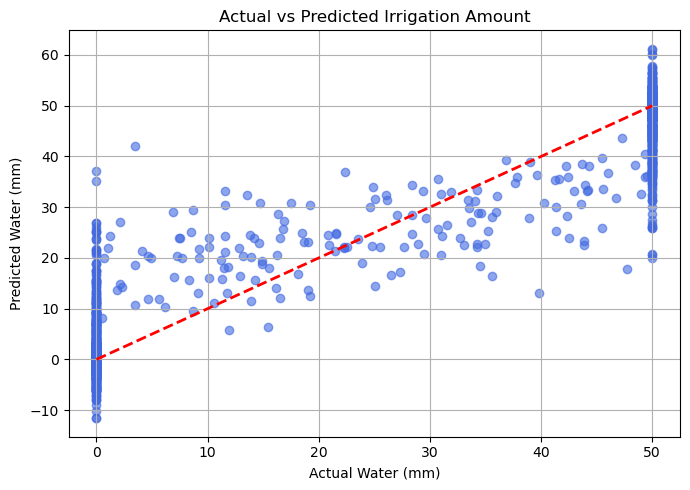

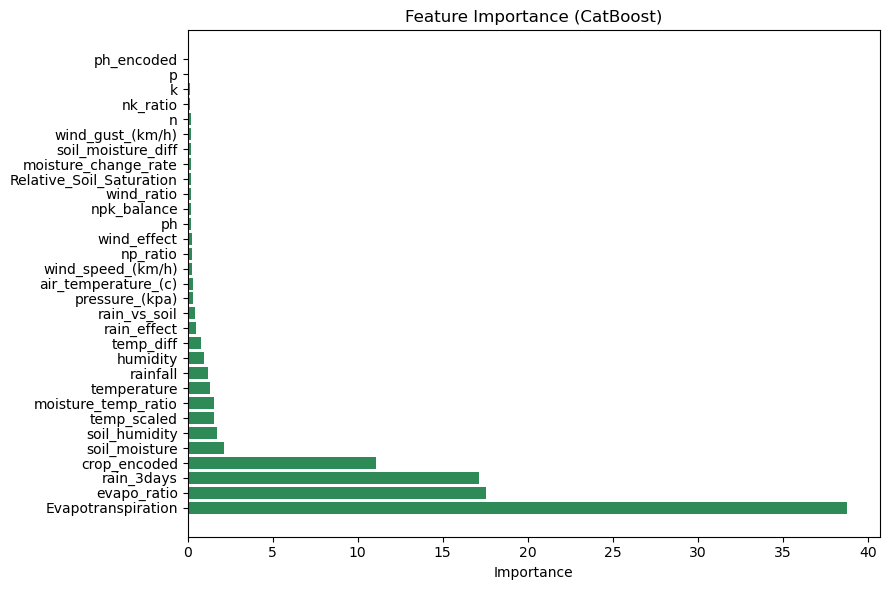

In [9]:
# Actual vs Predicted Scatter Plot
plt.figure(figsize=(7,5))
plt.scatter(y_test, y_pred, alpha=0.6, color='royalblue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Water (mm)')
plt.ylabel('Predicted Water (mm)')
plt.title('Actual vs Predicted Irrigation Amount')
plt.grid(True)
plt.tight_layout()
plt.show()

# Feature Importance Bar Plot
importances = model.get_feature_importance()
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(9,6))
plt.barh(np.array(features)[indices], np.array(importances)[indices], color='seagreen')
plt.xlabel('Importance')
plt.title('Feature Importance (CatBoost)')
plt.tight_layout()
plt.show()